# 7.1 Processing raw data
This section combines the raw data, the adjustments and cleaned bars to get processed 1-minute data. After processing we also detect the halts to create a <code>halted</code> flag. There are no gaps for processed data. All stocks that are active on a certain day have minute bars for every minute, from pre to post market, even if no trades took place. Empty bars are forward filled. Only for the first day, backwards filling may be done. All processed data will have the following columns: <code>['open', 'high', 'low', 'close', 'close_original', 'turnover', 'tradeable']</code>. Turnover is the dollar amount the stock has traded and is volume * close. Volume is an useless number on its own, as 1000 volume for a $200k stock is not the same as with a $0.1 stock. The 'close_original' is the unadjusted price. This is needed for filtering, e.g. only the stocks above $1. 

The steps:
1. The bars are split and dividend adjusted. (Split adjustment is done first, then dividend adjustment. Polygon already gives the adjusted dividends, so there is no need to split-adjust dividends.)
2. After this, the data is forward filled. If there are still NA values, the data is backward filled. Forward/backward filled bars are flagged by setting <code>tradeable</code> to False.
3. The true start/end dates are determined for each stock.

To make the loop more readable, we will first build the functions <code>split_adjust</code>, <code>dividend_adjust</code> and <code>detect_halts</code>.

In [34]:
from tickers import get_tickers
from times import get_market_calendar
from datetime import datetime, date, time
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
DATA_PATH = "../data/polygon/"

# 7.2 Split adjustment

In [35]:
adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/TSLA.csv", parse_dates=True, index_col=0)
bars = pd.read_parquet(DATA_PATH + f"raw/m1/TSLA-2019-06-03.parquet")

adjustments.index = pd.to_datetime(adjustments.index).date
splits = adjustments[adjustments.type == "SPLIT"].copy()

In [36]:
splits

,type,subtype,amount
2020-08-31,SPLIT,N,0.200000
2022-08-25,SPLIT,N,0.333333


In [37]:
trading_dates_ticker = sorted(list(set(bars.index.date)))

# The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
splits = splits.drop(columns=['type', 'subtype', 'amount'])
splits

,cumulative_adjustment
2020-08-31,0.066667
2022-08-25,0.333333


In [38]:
splits.index = splits.index.map(lambda day : max(d for d in trading_dates_ticker if d < day)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
splits

,cumulative_adjustment
2020-08-28,0.066667
2022-08-24,0.333333


In [39]:
splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [40]:
splits[splits.index > date(2019, 3, 26)][:5]

,cumulative_adjustment
2019-06-03,0.066667
2019-06-04,0.066667
2019-06-05,0.066667
2019-06-06,0.066667
2019-06-07,0.066667


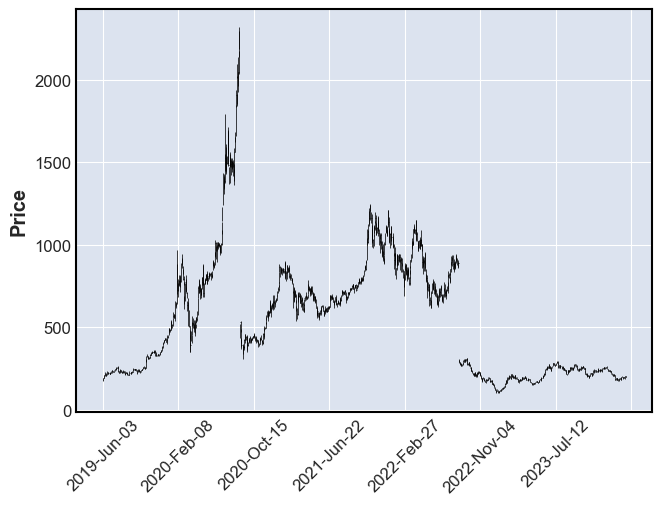

In [41]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [42]:
bars['date'] = bars.index.date
bars = bars.merge(splits, left_on='date', right_index=True, how='left')
bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].\
    multiply(bars["cumulative_adjustment"], axis="index")
bars['close_original'] = bars['close']

bars['turnover'] = bars['volume'] * bars['close_original']

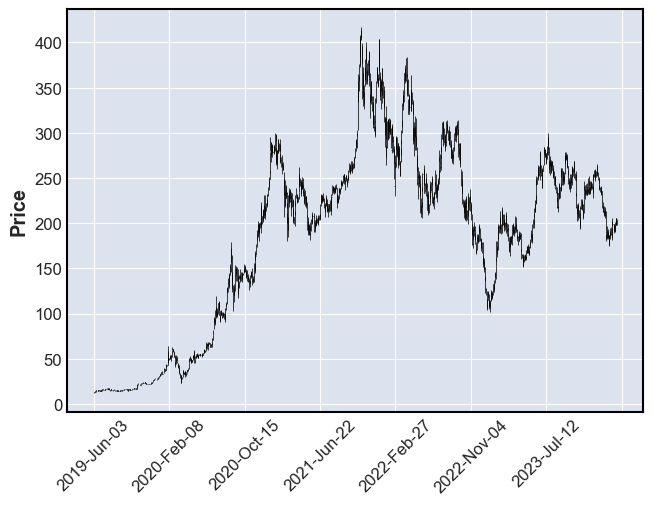

In [43]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

Putting it all together in a function yields:

In [44]:
def split_adjust(bars, ticker):
    """
    Returns the split-adjusted bars and add a column with the original close price.,
    If there is no split-data, the original bars are returned.
    """
    bars['close_original'] = bars['close']
    bars['turnover'] = bars['volume'] * bars['close_original']

    if not os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
        return bars[['open', 'high', 'low', 'close', 'close_original', 'turnover']]
    
    adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)
    adjustments.index = pd.to_datetime(adjustments.index).date
    trading_dates_ticker = sorted(list(set(bars.index.date)))
    adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & (adjustments.index <= trading_dates_ticker[-1])]

    splits = adjustments[adjustments.type == "SPLIT"].copy()

    # Adjust for splits
    if not splits.empty:
        splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
        splits = splits.drop(columns=['type', 'subtype', 'amount'])
        splits.index = splits.index.map(lambda day : max(d for d in trading_dates_ticker if d < day))
        splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
        splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) 

        # Merge adjustments with the bars and adjust
        bars['date'] = bars.index.date
        bars = bars.merge(splits, left_on='date', right_index=True, how='left')
        bars['close_original'] = bars['close']
        bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].\
            multiply(bars["cumulative_adjustment"], axis="index")

        bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

    return bars[['open', 'high', 'low', 'close', 'close_original', 'turnover']]

# 7.3 Dividend adjustment
We use the [stockcharts](https://support.stockcharts.com/doku.php?id=policies:historical_price_data_is_adjusted_for_splits_dividends_and_distributions#:~:text=Dividend%20Adjustment%20Calculation%20Details%3A,then%20multiplied%20by%20this%20factor) or [Yahoo](https://help.yahoo.com/kb/SLN28256.html) method to adjust dividends, which mimics dividend reinvesting at the close of cum-dividend date. If at cum-dividend the price is 60, and at ex-dividend is 50 after a 10/share dividend, then all prices from cum-dividend and before are adjusted by the factor *1 - (dividend/cumdividend close)*. So the adjusted cum-dividend close will be 50. 

Note: Even though the close (which can differ on early close days) is used to calculate the adjustment factor, the post-market prices also have to be adjusted. 

In [45]:
split_adjusted_bars = split_adjust(pd.read_parquet(DATA_PATH + f"raw/m1/BIL-2019-06-01.parquet"), 'BIL')
trading_dates_ticker = sorted(list(set(bars.index.date)))

adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/BIL.csv", parse_dates=True, index_col=0)
adjustments.index = pd.to_datetime(adjustments.index).date
adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & (adjustments.index <= trading_dates_ticker[-1])]

split_adjusted_dividends = adjustments[adjustments.type == "DIV"].copy()
split_adjusted_dividends.head(3)

,type,subtype,amount
2019-07-01,DIV,CD,0.165078
2019-08-01,DIV,CD,0.154507
2019-09-03,DIV,CD,0.168404


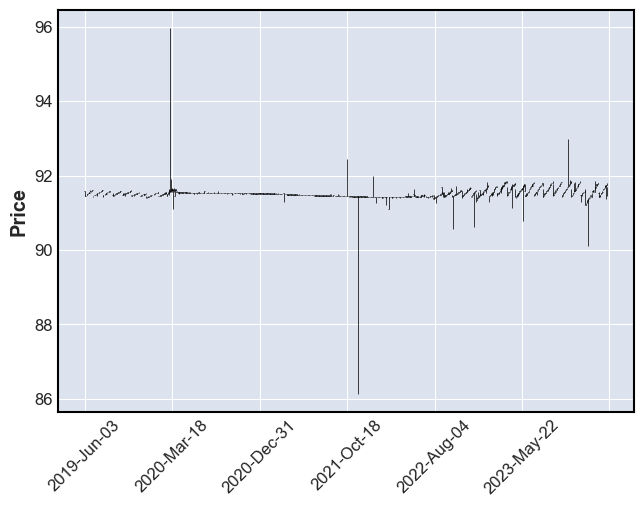

In [46]:
daily = split_adjusted_bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

Let's first get the cum_div_dates.

In [47]:
split_adjusted_dividends['cum_div_date'] = split_adjusted_dividends.index.map(\
    lambda day : max(d for d in trading_dates_ticker if d < day))
split_adjusted_dividends = split_adjusted_dividends[['amount', 'cum_div_date']]
split_adjusted_dividends.index.names = ['ex_div_date']
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2019-07-01,0.165078,2019-06-28
2019-08-01,0.154507,2019-07-31
2019-09-03,0.168404,2019-08-30


In [48]:
# We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
market_hours = get_market_calendar('datetime')
market_hours = market_hours[['regular_close']]

In [49]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True)
split_adjusted_dividends['cum_div_datetime'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']

# Sometimes the latest trade of the day is NOT the 15:59 bar exactly. 
# So we need to get the latest available price at or before the close.
split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(\
    lambda dt : (split_adjusted_bars[split_adjusted_bars.index <= dt].index).max())
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
split_adjusted_dividends['cum_div_close'] = split_adjusted_bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

In [50]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_datetime,cum_div_close
cum_div_datetime,,,,
2019-06-28 15:59:00,0.165078,2019-06-28,2019-06-28 15:59:00,91.620
2019-07-31 15:59:00,0.154507,2019-07-31,2019-07-31 15:59:00,91.605
2019-08-30 15:59:00,0.168404,2019-08-30,2019-08-30 15:59:00,91.620


In [51]:
split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()

In [52]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_datetime,cum_div_close,adjustment,cumulative_adjustment
cum_div_datetime,,,,,,
2019-06-28 15:59:00,0.165078,2019-06-28,2019-06-28 15:59:00,91.620,0.998198,0.918868
2019-07-31 15:59:00,0.154507,2019-07-31,2019-07-31 15:59:00,91.605,0.998313,0.920527
2019-08-30 15:59:00,0.168404,2019-08-30,2019-08-30 15:59:00,91.620,0.998162,0.922082


In [53]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

# Get dividend adjustments for every trading day (same procedure as split adjustments)
dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [54]:
dividend_adjustments.head(3)

,cumulative_adjustment
cum_div_date,
2019-06-03,0.918868
2019-06-04,0.918868
2019-06-05,0.918868


In [55]:
# Same procedure as with split adjustments
all_adjusted_bars = split_adjusted_bars.copy()
all_adjusted_bars['date'] = all_adjusted_bars.index.date
all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].\
    multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")
all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

# Round to 4 decimals
all_adjusted_bars = round(all_adjusted_bars, 4)

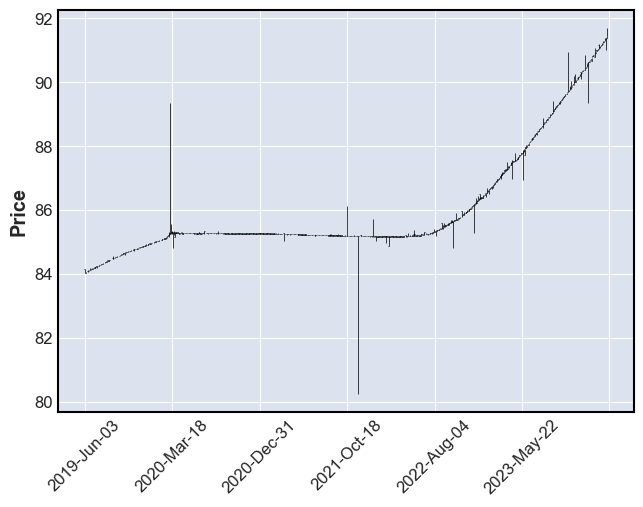

In [56]:
daily = all_adjusted_bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

Putting it all in a function yields:

In [57]:
def div_adjust(split_adjusted_bars, ticker):
    """
    Dividend-adjust the 1-minute bars.
    """
    if not os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
        return split_adjusted_bars
    
    trading_dates_ticker = sorted(list(set(split_adjusted_bars.index.date)))

    adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)
    adjustments.index = pd.to_datetime(adjustments.index).date
    adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & \
                                (adjustments.index <= trading_dates_ticker[-1])]
    split_adjusted_dividends = adjustments[adjustments.type == "DIV"].copy()
    
    all_adjusted_bars = split_adjusted_bars.copy()

    if not split_adjusted_dividends.empty:
        # Get cum div date
        split_adjusted_dividends['cum_div_date'] = split_adjusted_dividends.index.map(\
            lambda day : max(d for d in trading_dates_ticker if d < day))
        
        split_adjusted_dividends = split_adjusted_dividends[['amount', 'cum_div_date']]
        split_adjusted_dividends.index.names = ['ex_div_date']

        # We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
        market_hours = get_market_calendar('datetime')
        market_hours = market_hours[['regular_close']]

        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True)
        split_adjusted_dividends['cum_div_datetime'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']

        # Sometimes the latest trade of the day is NOT the 15:59 bar exactly. 
        # So we need to get the latest available price at or before the close.
        split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(\
            lambda dt : (split_adjusted_bars[split_adjusted_bars.index <= dt].index).max())
        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
        split_adjusted_dividends['cum_div_close'] = split_adjusted_bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

        # Calculate adjustments
        split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
        split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()

        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
        dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

        dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
        dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].\
            fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

        # Same procedure as with split adjustments
        all_adjusted_bars['date'] = all_adjusted_bars.index.date
        all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
        all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].\
            multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")

        all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

    # Round to 4 decimals
    return round(all_adjusted_bars, 4)

# 7.4 Reindexing and NA values

When reindexing we need to get a list of all minutes. Since we will also have to do this in the backtester (which loops over the minutes), we will store it and create a function to retrieve it.

In [58]:
market_hours = get_market_calendar()

# Get all minutes from trading days
trading_datetimes = pd.date_range(start=market_hours.index[0], \
                                  end=datetime.combine(market_hours.index[-1], time(23, 59)), freq='min', name='datetime')
trading_datetimes[(trading_datetimes.time >= time(4, 0)) & (trading_datetimes.time <= time(19, 59))]

# Filter to all trading minutes in trading days
trading_datetimes = trading_datetimes[trading_datetimes.to_series().dt.date.isin(market_hours.index)]
trading_datetimes = trading_datetimes[(trading_datetimes.time >= time(4)) & (trading_datetimes.time <= time(19, 59))] 

# Remove the minutes in early closes (from 17:00 to 19:59 there is no post-market on early close days)
early_closes = market_hours[market_hours['postmarket_close'] != time(19, 59)]
for day, early_close in early_closes.iterrows():
    postmarket_close = early_close['postmarket_close']
    trading_datetimes = trading_datetimes[~((trading_datetimes > datetime.combine(day, early_close['postmarket_close'])) \
                                            & (trading_datetimes <= datetime.combine(day, time(19, 59)) ) )] 

pd.DataFrame(index=trading_datetimes).to_parquet(DATA_PATH + 'market/trading_minutes.parquet')

In [59]:
from functools import lru_cache

# This decorator ensures that when we call a function the output is stored for future calls.
# This is useful if executing the function is expensive and gets called a lot.
@lru_cache
def get_market_minutes():
    trading_datetimes = pd.read_parquet(DATA_PATH + 'market/trading_minutes.parquet')
    return pd.to_datetime(trading_datetimes.index)

In [60]:
def reindex_and_fill(bars):
    # Get the days the ticker is trading
    ticker_days = sorted(list(set(bars.index.date)))
    market_datetimes = get_market_minutes()
    ticker_datetimes = market_datetimes[(market_datetimes.date >= ticker_days[0]) & (market_datetimes.date <= ticker_days[-1])]

    # Reindex
    bars = bars.reindex(ticker_datetimes)

    # Fill NA values
    bars['tradeable'] = ~bars['turnover'].isna()
    bars['turnover'] = bars['turnover'].fillna(value=0) 

    bars["close"] = bars["close"].fillna(method="ffill")
    bars["close_original"] = bars["close_original"].fillna(method="ffill")
    bars["open"] = bars["open"].fillna(bars["close"])
    bars["low"] = bars["low"].fillna(bars["close"])
    bars["high"] = bars["high"].fillna(bars["close"])

    # Only affects the very start. Else backfill shouldn't be used because of look-ahead bias.
    bars["open"] = bars["open"].fillna(method="bfill")
    
    bars["close"] = bars["close"].fillna(bars["open"])
    bars["close_original"] = bars["close_original"].fillna(method='bfill') # Technically we should get the open_original, but I am not going to bother with the untradeable bars at the start that will never be used.
    bars["low"] = bars["low"].fillna(bars["open"])
    bars["high"] = bars["high"].fillna(bars["open"])
    
    return bars

In [61]:
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BIL-2019-06-01.parquet")
split_adjusted_bars = split_adjust(bars, "BIL")
all_adjusted_bars = div_adjust(split_adjusted_bars, "BIL")
reindex_and_fill(all_adjusted_bars).head(3)

,open,high,low,close,close_original,turnover,tradeable
datetime,,,,,,,
2019-06-03 04:00:00,84.15,84.15,84.15,84.15,91.58,88374.7,True
2019-06-03 04:01:00,84.15,84.15,84.15,84.15,91.58,0.0,False
2019-06-03 04:02:00,84.15,84.15,84.15,84.15,91.58,0.0,False


# 7.5 Halt detection
**I decided to skip halt detection, as the flag may not be very useful as most of the time it is just an inverse of 'tradeable'. Nevertheless, I will not delete this section of code to show how it is done.**

We cannot detect all halts without tick data. However we are not interested in pre- and post-market halts anyways. We care about the liquid stocks that are halted intraday and have decent volume. Halts take a minimum of 5 minutes. This means at least 4 OHLC 1-minutes bars with no data, because a halt can start *during* the OHLC bar.

For each stock where the turnover is more than 2.5 million dollars we will check whether there are 4 empty bars during regular hours. Illiquid stocks do not trade all minutes and may be incorrectly flagged. This happens quite often.

The best way to do this is to flag all 'suspicious' empty periods and check with tick data if the quotes dissapear. However I do not yet have access to tick data. When we have tick data, we can just loop over the minutes with a 'halted' flag True and check if there exist quotes. 

In [62]:
# bars = pd.read_parquet(DATA_PATH + f"raw/m1/TOP-2022-06-01.parquet")
# bars = split_adjust(bars, 'TOP')
# bars = reindex_and_fill(bars)
# bars = bars[['open', 'high', 'low', 'close', 'volume', 'tradeable']]
# dump = bars[(bars.index >= datetime(2023, 5, 4, hour=10, minute=45)) & (bars.index <= datetime(2023, 5, 4, hour=11, minute=8))].copy()

# mpf.plot(dump, type='candle', style='yahoo', show_nontrading=False, title="TOP intraday halts on 2023-05-04")

It is handy to first create a function to remove the non-regular market hours from the minute bars.

In [63]:
def remove_extended_hours(bars):
    """
    Remove extended hours.
    """
    # Remove non-regular trading minutes. Only the post-market hours of early closes remain.
    bars = bars.between_time("9:30", "15:59")

    # Remove early close post-market bars
    market_hours = get_market_calendar()
    early_closes = market_hours[market_hours["regular_close"] != time(15, 59)]
    for date_, early_close in early_closes.iterrows():
        bars = bars[
            ~(
                (bars.index > datetime.combine(date_, early_close["regular_close"]))
                & (bars.index <= datetime.combine(date_, time(19, 59)))
            )
        ]

    return bars

In [64]:
# def flag_halts(bars):
#     """
#     Only flags intraday halts for stocks >2.5M turnover. May get false-positive if there is low volume.
#     """
#     bars_halted = remove_extended_hours(bars)
#     bars_halted = bars_halted[["close", "turnover", "tradeable"]]
    
#     # Filter for volume
#     # To reduce false-positives, also filter for stocks that had at least 240 minutes of trading during regular hours.
#     daily = bars_halted[['turnover', 'close', 'tradeable']].resample('D').agg({'turnover': 'sum', 'close': 'last', 'tradeable': 'sum'})
#     daily = daily[(daily['turnover'] > 2_500_000) & (daily['tradeable'] > 240)]
#     has_volume = daily.index.date

#     bars_halted['date'] = bars_halted.index.date
#     bars_halted = bars_halted[bars_halted['date'].isin(has_volume)]

#     # Flag if 4x untradeable one after another. Only the 4-th (and lager) occasion is flagged.
#     bars_halted['halted_for_4+'] = (~bars_halted["tradeable"]).rolling(4).sum() >= 4
#     # Also flag the 1st, 2nd and 3rd occasion.
#     bars_halted['halted'] = bars_halted['halted_for_4+'].replace(to_replace=False, method='bfill', limit=3)

#     bars = bars.merge(bars_halted['halted'], how='left', left_index=True, right_index=True)
#     bars['halted'] = bars['halted'].fillna(False)
#     return bars

In [65]:
# bars = flag_halts(bars)
# bars[(bars.index >= datetime(2023, 5, 4, hour=10, minute=49)) & (bars.index <= datetime(2023, 5, 4, hour=11, minute=0))]

# 7.6 Putting it all in a loop

In [77]:
tickers_v3 = get_tickers(v=3)
for index, row in tickers_v3.iterrows():
    id = row['ID']
    ticker = row["ticker"]
    
    try:
        bars = pd.read_parquet(f"{DATA_PATH}raw/m1/{id}.parquet")
    except FileNotFoundError:
        print(f"There is no data for {id}")
        continue

    # ADJUSTING
    split_adjusted_bars = split_adjust(bars, ticker)
    all_adjusted = div_adjust(split_adjusted_bars, ticker)

    # FORWARD FILLING
    all_adjusted = reindex_and_fill(all_adjusted)

    # ROUNDING: TO 4 DECIMALS, TURNOVER TO INT
    all_adjusted = round(all_adjusted, 4)
    all_adjusted['turnover'] = all_adjusted['turnover'].astype(int)
    
    all_adjusted.to_parquet(DATA_PATH + f"processed/m1/{id}.parquet", engine="fastparquet", row_group_offsets=25000)

Later on, I got an error which was caused by stock prices being negative. This is caused by some special events (with a dividend type of 'SC'), where Polygon has already adjusted for it... We avoid this problem by manually deleting the dividend in the adjustment:
* GEN: 2020-02-03
* LIAN: 2024-02-26

# 7.7 Updating the ticker list
Now that we have the data, we can add two columns <code>start_data</code> and <code>end_data</code>.

In [ ]:
import pyarrow.parquet as pq

tickers_v3 = get_tickers(v=3)
tickers_v3["start_data"] = np.nan
tickers_v3["end_data"] = np.nan

for index, row in tickers_v3.iterrows():
    id = row['ID']
    try:
        dataset = pq.ParquetFile(DATA_PATH + f"processed/m1/{id}.parquet")
    except FileNotFoundError:
        print(f"There is no data for {id}")
        continue

    # Reading metadata (statistics) of first and last row group. This avoids reading the entire file.
    # Reading everything from the datetime column and getting first/last row took 8 minutes. This took less than 50 sec.
    metadata_first_row_group = dataset.metadata.row_group(0)
    metadata_last_row_group = dataset.metadata.row_group(dataset.num_row_groups-1)
    # Retrieve statistics
    min_date = metadata_first_row_group.column(0).statistics.min
    max_date = metadata_last_row_group.column(0).statistics.max
    # Convert to date
    start_data = min_date.to_pydatetime().date()
    end_data = max_date.to_pydatetime().date()
    
    tickers_v3.loc[tickers_v3['ID'] == id, ["start_data", "end_data"] ] = [start_data, end_data]
    print(index)

tickers_v3.reset_index(inplace=True)
tickers_v3[["ID", "ticker", "name", "active", "start_date", "end_date", "start_data", "end_data", "type", "cik", "composite_figi"]].to_csv("../data/tickers_v4.csv")

In [68]:
tickers_v4 = get_tickers(v=4)
tickers_v4['start_data'] = pd.to_datetime(tickers_v4['start_data']).dt.date
tickers_v4['end_data'] = pd.to_datetime(tickers_v4['end_data']).dt.date
tickers_v4.iloc[:3, :9].head(3)

,ID,ticker,name,active,start_date,end_date,start_data,end_data,type
0,A-2019-06-03,A,Agilent Technologies Inc.,True,2019-06-03,2024-03-01,2019-06-03,2024-03-01,CS
1,AA-2019-06-03,AA,Alcoa Corporation,True,2019-06-03,2024-03-01,2019-06-03,2024-03-01,CS
2,AABA-2019-06-03,AABA,Altaba Inc. Common Stock,False,2019-06-03,2019-10-04,2019-06-03,2019-10-02,CS


Some stocks have zero data. There are the tickers with only ghost days. We can safely remove those.

In [69]:
zero_data = tickers_v4[(tickers_v4['start_data'].isna() & (tickers_v4['type'] != "INDEX"))]
print(len(zero_data))
zero_data.iloc[:3, :9].head(3)

48


,ID,ticker,name,active,start_date,end_date,start_data,end_data,type
26,AAXN-2023-09-08,AAXN,"Axon Enterprise, Inc. Common Stock",True,2023-09-08,2024-03-01,NaT,NaT,CS
41,ABIL-2023-09-08,ABIL,Ability Inc Ordinary Shares,True,2023-09-08,2024-03-01,NaT,NaT,CS
110,ACRV-2022-11-10,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,NaT,NaT,CS


In [70]:
tickers_v4 = tickers_v4[~(tickers_v4['start_data'].isna() & (tickers_v4['type'] != "INDEX"))]
tickers_v4.reset_index(inplace=True, drop=True)
tickers_v4.to_csv("../data/tickers_v4.csv")

# 7.8 Updates
Not implemented. However, we should only process the tickers that had splits/divs in the update period. The rest only has to be reindex/filled+flagged. Then appended.

For now, just rerun everything after updating END_DATE.